In [1]:
%load_ext autoreload
%autoreload 2

import markovlink
import numpy as np
import numpy.random as npr
import scipy as sp
import pickle
import matplotlib.pylab as plt
%matplotlib inline

# the input

In [2]:
# example input: two matrices, Nly and Nlx
with open('exampletables.pkl','rb') as f:
    locals().update(pickle.load(f))

Our original data comes in the form of two tables.

The first table, `Nlx`, gives the result of running technique I one some data.  This technique takes in a given specimen and returns one of a finite number of different responses, each of which tells us something different about the specimen.  In this case, these responses corresponded to guesses about the cell type of the specimens, which were cells.  In general, any measurement tool that gives one of a discrete number of responses can be used (or, if the response is continuous, we can bin responses to make them discrete).  

To be concrete: `Nlx[l,x]` gives the  the number of samples from subpopulation `l` that that measured as `x` by technique I.  We expect `Nlx` to be a numpy matrix, or something that `np.require` will turn into a matrix.

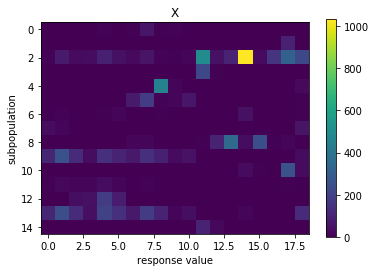

In [37]:
plt.imshow(Nlx); plt.ylabel('subpopulation'); plt.xlabel("response value"); plt.colorbar();
plt.title("X")
plt.savefig("images/Nlx.png",dpi=300,bbox_inches='tight')

The second table, `Nly`, is based on a completely different dataset, run on completely different specimens, with completely different technique.  These specimens were treated with technique II, which also returns one of a finite number of different responses.   `Nly[l,y]` gives the number of samples from subpopulation `l` that were measured as `y` by technique II.

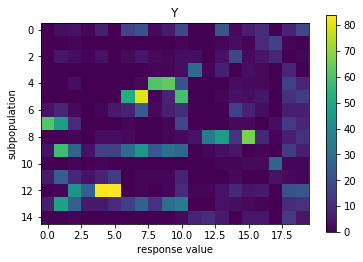

In [38]:
plt.imshow(Nly); 
plt.ylabel('subpopulation'); plt.xlabel("response value"); plt.colorbar();
plt.title("Y")
plt.savefig("images/Nly.png",dpi=300,bbox_inches='tight')

In no case was the *same specimen* observed using both techniques.  However, both techniques sampled from the same set of subpopulations.  Using a Markov Link assumption, this enables us to determine a set of possible calibrations, or correspondences between the two methods.

# The Markov Link Method

The first step is to estimate the distribution of $p(x|\ell)$, using our tables.  We do this by simply taking the empirical distribution with a simple psuedocount.  Just for point of reference, let's also look at the distribution of $p(y|\ell)$.

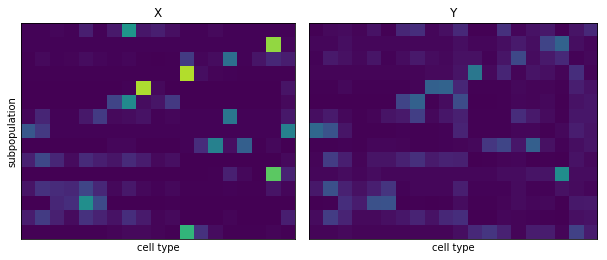

In [58]:
plx = (Nlx+1) / np.sum(Nlx+1,axis=1,keepdims=True) # we use psuedocounts
ply = (Nly+1) / np.sum(Nly+1,axis=1,keepdims=True) # we use psuedocounts

plt.gcf().set_size_inches(20,10)

ax=plt.gcf().add_axes([0,0,plx.shape[1]/100.0,1])
plt.imshow(plx,vmin=0,vmax=1); plt.title("X"); plt.xticks([]); plt.yticks([]);
plt.ylabel("subpopulation")
plt.xlabel("cell type")

ax=plt.gcf().add_axes([.2,0,ply.shape[1]/100.0,1])
plt.imshow(ply,vmin=0,vmax=1); plt.title("Y"); plt.xticks([]); plt.yticks([]);
plt.xlabel("cell type")

plt.savefig("images/plxy.png",dpi=300,bbox_inches='tight')

Using this and the Nly data, the markov link method gives us a way to estimate $q(y|x)$.

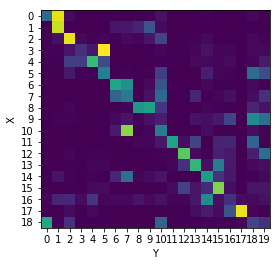

In [61]:
qhat = markovlink.train_q(plx,Nly,kappa=.1)
plt.imshow(qhat)
plt.ylabel('X')
plt.xlabel("Y")
plt.xticks(np.r_[0:qhat.shape[1]])
plt.yticks(np.r_[0:qhat.shape[0]])
plt.savefig("images/qhat.png",dpi=300,bbox_inches='tight')

# the accuracy of qhat

In traditional estimation of parameters, there is a **not-enough data problem** that must always be overcome.  Since we have only a finite amount of data and there is some randomness, it is not clear whether our estimate is close to the truth.  In some sense the whole field of statistics was born in order to address this problem.  It is an issue we will also face here.  We can use traditional tools such as the bootstrap to try to get a sense for the depth of this problem in any given situation.

There is also often a **modelling problem**.  In this enterprise we have made a Markov assumption.  If this assumption is incorrect, then our results may be somewhat meaningless.  To get some sense for whether our model might be right, we can use a traditional held-out-log-likelihood sort of method.  We train on some of the data, and then see whether our model looks good on data we did not train on.  If it doesn't perform well when compared with other models, that would be a red flag.  

In the Markov Link Method we face an additional hurdle which is less commonly encountered: an **identifiability problem**.  Even if we had an *infinite* amount of data, the Markov Link Method estimator for $q(y|x)$ is not guaranteed to be close to the truth in the general case.  This is because the data doesn't directly tell us what we're interested in: we want to know the relationship between $X$ and $Y$, but instead we get one dataset helping us understand the $\ell,X$ relationship and another dataset helping us understand the $\ell,Y$ relationship.  In light of this challenge, it is not immediately obvious how to get a sense for whether our estimate for $q(y|x)$ is close to the truth.  In the paper, we develop new tools to understand these issues rigorously.

Let us look at these problems one at a time.

# Not-enough data problem

To get a measure of how confidence we should be in our estimates, we use two different bootstrap techniques.

### Nonparametric bootstrap

Here we simply resamples all the data, with replacement, and see whether our result changes.  By doing this many times we can get a sense for error due to insufficient data.

In [28]:
qhat2s=[]
for i in range(50):
    Nlx2=markovlink.criticize.resample(Nlx)
    Nly2=markovlink.criticize.resample(Nly)
    plx2 = (Nlx2+1) / np.sum(Nlx2+1,axis=1,keepdims=True) # we use psuedocounts
    qhat2s.append(markovlink.train_q(plx2,Nly2,kappa=.1))

Let's look at 9 of the different values we got.

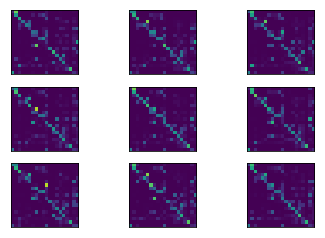

In [29]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(qhat2s[i],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])
plt.savefig("images/nonparametricbootstrap.png",dpi=300,bbox_inches='tight')

Qualitatively, we can see that some aspects of the estimate are highly stable, but others are less so.  We can measure this quantitatively by measuring the average Euclidean distance between qhat and the bootstrap estimates.

In [30]:
np.mean(np.sqrt(np.sum(np.sum(np.array(qhat2s)-qhat[None,:,:],axis=1)**2,axis=1)))

0.6623235806587947

This distance (when one considers that it reflects differences over all the many entries of the matrix qhat) indicates that every bootstrap sample is in fact fairly close to our original estimate qhat.  

### parametric bootstrap

Another technique is a more "parametric bootstrap."  Here we pretend our learned model is correct.  We then resample the data from our learned model, try to learn from the resampled data, and see how closely it matches our original model.  This is much the same as the nonparametric bootstrap, except instead of sampling Nly with replacement from the original dataset, we sample it according to our model. 

In [31]:
Nlysums= np.sum(Nly,axis=1)
h = plx @ qhat

qhat2s=[]
for i in range(50):
    Nlx2=markovlink.criticize.resample(Nlx)
    Nly2=np.array([npr.multinomial(Nlysums[i],h[i]) for i in range(len(h))])
    plx2 = (Nlx2+1) / np.sum(Nlx2+1,axis=1,keepdims=True) # we use psuedocounts
    qhat2s.append(markovlink.train_q(plx2,Nly2,kappa=.1))

As we would hope, we obtain similar results:

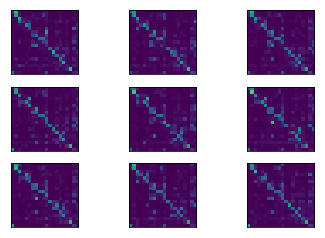

In [32]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(qhat2s[i],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])
plt.savefig("images/parametricbootstrap.png",dpi=300,bbox_inches='tight')

In [33]:
np.mean(np.sqrt(np.sum(np.sum(np.array(qhat2s)-qhat[None,:,:],axis=1)**2,axis=1)))

0.7406168823700799

Although the distance is small, it can be useful to look at the variation over the matrix:

([], <a list of 0 Text yticklabel objects>)

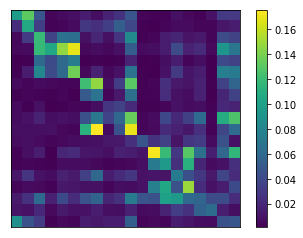

In [34]:
plt.imshow(np.std(qhat2s,axis=0))
plt.colorbar(); plt.xticks([]); plt.yticks([])

We see that there are certain hotspots where the ambiguity is greater.  This can help us design future experiments: we need more data for the kinds of cell that currently face ambiguity.

# Modelling problems

We have assumed that our data can be modeled as $p(X|\ell)q(Y|X)$.  Due to the limitations of our data, it is not possible to ever be sure whether this assumption is really correct.  However, there are some limited checks we can perform, and would be be remiss if we ignored them.

One basic test would be to make sure that our model performs well on aspects of the data we *can* test.  In particular, our trained model implies a very specific distriution for $\mathbb{P}(Y=y|\ell)$, namely $h(y|\ell)\triangleq \sum_x p(X|\ell)q(y|x)$.  On the other hands, there are other more conventional ways of estimating the distribution of $\mathbb{P}(Y=y|\ell)$ from the data we have -- namely by using an empirical distribution.  We can compare these two methods for estimating $\mathbb{P}(Y=y|\ell)$ in terms of how well they model held-out data.

First we split data into training data and testing data:

In [14]:
print("We have",np.sum(Nly),"total samples")
holdout=25
Nly_train,Nly_test = markovlink.train_test_split(Nly,holdout)
print("Now we have",np.sum(Nly_train),"samples to train p(y|l) and",np.sum(Nly_test),"samples to test on")

We have 2281.0 total samples
Now we have 1906.0 samples to train p(y|l) and 375.0 samples to test on


Train the model on just the training data

In [15]:
# a version of qhat trained only on just the training data
qhat_train = markovlink.train_q(plx,Nly_train,kappa=.1)

# this yields an estimate for the distribution P(y|l)
h_train = plx @ qhat_train

Train a more traditional traditional estimate for $p(y|\ell)$

In [16]:
h_train2=Nly_train.copy()
h_train2=h_train2+1.0 # pseudocount of 1.0
h_train2=h_train2/np.sum(h_train2,axis=1,keepdims=True)

We can then compare the two methods.  Fewer nats is better, as it indicates that our model provides a more concise representation of the new observations.  

In [17]:
lik=np.sum(np.log(h_train2)*(Nly_test)) / np.sum(Nly_test)
print("Cost of coding with traditional estimate: %.2f nats per entry"%(-lik))

Cost of coding with traditional estimate: 2.21 nats per entry


In [18]:
lik=np.sum(np.log(h_train2)*(Nly_train)) / np.sum(Nly_train)
print("Cost of coding with traditional estimate: %.2f nats per entry"%(-lik))

Cost of coding with traditional estimate: 2.14 nats per entry


This is encouraging.  Our model agrees with the more traditional estimate.  In fact, it is able to slightly outperform the traditional estimate, perhaps because it somewhat leverage our data about $X$ to help us learn about the distributions on $Y$.

# Identifiability problems

It is easy to show that even in the limit of infinite data, our estimated value, qhat, will *not* approach the true value, qstar.  This is because the nature of the data we have makes it impossible.  Indeed, we can only observe samples of $\ell,X$ and samples of $\ell,Y$ but never samples of $X,Y$ together, so this should be no surprise.

However, even though we can never find a perfect estimator for qstar, we *can* find an estimator which is consistent for qstar *up to some error*.  What's more, we can estimate exactly how bad that error is.

Formally, we articulate this by constructing a polytope of possible values that qstar might be: $\hat \Theta$={q: plx@q=plx@qhat}.  In our paper we show that although qhat is not consistent, the polytope $\hat \Theta$ is consistent for the true polytope $\Theta$={q: pstar@q=pstar@qstar}, where pstar,qstar indicate the true distribution.  Thus, if we can show that estimated polytope is closely centered around qhat, then we *know* that the true qstar is also very close to our qhat (modulo concerns about not-enough-data and modeling, as we mentioned before).

Thus, we can determine how much we need to be concerned about identifiability by looking at the **size** of the polytope $\hat \Theta$.  If the polytope is tightly centered around qhat, then we actually *do* have a consistent estimator for the true qstar, up to an error bounded by the size of that polytope.

There are a few ways we can look at the polytope to see how big it is.

### By RUX samples

One way to try to get a sense of the set $\hat \Theta$: take samples of the extremal vertices that define the set.

In [19]:
ruxs=markovlink.sample_rux(plx,qhat,6)

(0/6)(1/6)(2/6)(3/6)(4/6)(5/6)

And we can look at those samples.  Each one gives a possible way that the two techniques might correspond.

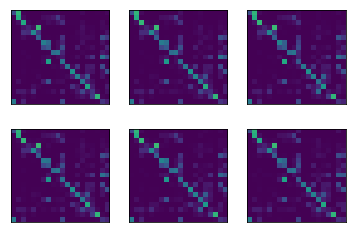

In [20]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(ruxs[i],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])
plt.savefig("images/rux.png",dpi=300,bbox_inches='tight')

In [62]:
np.mean(np.sqrt(np.sum(np.sum(np.array(ruxs)-qhat[None,:,:],axis=1)**2,axis=1)))

0.16673587064438578

Note that the samples have a lot in common.  If an aspect of the samples is in common among many samples, then we have cause to believe that that aspect is present in the true correspondence.  (In particular, in the limit of infinite data we are guaranteed precisely that...)

We can also look at samples drawn uniformly from the polytope.  

In [21]:
unifs=markovlink.sample_uniform(plx,qhat,1000,verbose=True)

(0/1000)(51/1000)(102/1000)(153/1000)(204/1000)(255/1000)(306/1000)(357/1000)(408/1000)(459/1000)(510/1000)(561/1000)(612/1000)(663/1000)(714/1000)(765/1000)(816/1000)(867/1000)(918/1000)(969/1000)

In our paper we used 10000 steps.  You may wish to use less.  The more steps you use, the better guarantee you will have that your samples are truly representative of the uniform distribution on the set of possible correspondences.

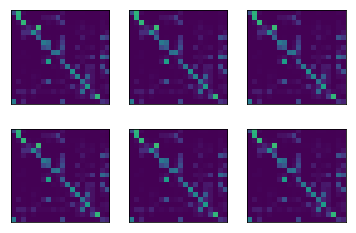

In [22]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(unifs[npr.randint(0,len(unifs))],vmin=0,vmax=1); plt.xticks([]); plt.yticks([])
plt.savefig("images/unif.png",dpi=300,bbox_inches='tight')

In [63]:
np.mean(np.sqrt(np.sum(np.sum(np.array(unifs)-qhat[None,:,:],axis=1)**2,axis=1)))

0.02706286612552672

Not surprisingly, these samples from the interior of the set also have much in common.  

Although there is much in common, it is worth looking at what is ambiguous.  These are places where additional data could be useful.

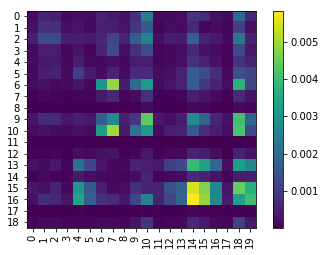

In [23]:
plt.imshow(np.std(unifs,axis=0))
plt.colorbar(); plt.xticks(np.r_[0:Nly.shape[1]],rotation='vertical'); plt.yticks(np.r_[0:Nlx.shape[1]]);

The rows which have high standard deviation are still somewhat ambiguous.  This is *not* a reflection of a lack of data, but rather a reflection of the *kind* of data which has been gathered.  Simply gathering more data will not help.  Instead, this helps us design new experiments.  It suggets we must find the subpopulations which can help us distinguish properly.  For example, looking at row 16 it is clear that we need to look at new subpopulations that could help us distinguish between column 14 and the other columns.